# Kaggle Pro 教学计划 - 数据挖掘项目
## 预测 Rossmann 未来的销售额

Rossmann是德国最大的日化用品超市，成立于1972年。在医药零售行业，目前Rossmann已经在7个欧洲国家拥有超过3000家药店。目前，Rossmann店铺经理的任务是**提前六周预测其日销量**。显然，商店销售受到诸多因素的影响，比如促销、竞争、假日、季节性和地点等等。 成千上万的个人经理根据各自店铺的情况预测销售量，结果的准确性可能会有很大的变化。

可靠的销售预测使商店经理能够创建有效的员工时间表，从而提高生产力和动力，比如更好的调整供应链和合理的促销策略与竞争策略，具有重要的实用价值与战略意义。 如果可以帮助Rossmann创建一个强大的预测模型，将帮助仓库管理人员专注于对他们最重要的内容：客户和团队。
因此，在这个项目中，Rossmann希望建立机器学习模型，通过给出的数据来预测德国各地1115家店铺的6周销量。

>**提示：**Code 和 Markdown 区域可通过 **Shift + Enter** 快捷键运行。此外，Markdown可以通过双击进入编辑模式。

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 1](#step1): 导入数据
* [Step 2](#step2): 数据研究
* [Step 3](#step3): 缺失值处理
* [Step 4](#step4): 特征提取
* [Step 5](#step5): 基准模型与测试
* [Step 6](#step6): XGBoost

在该项目中包含了如下的问题：

* [问题 1](#question1): 回顾课上内容并查阅资料，归纳总结缺失值的处理方法。
* [问题 2](#question2): 这里评分标准为何采用`neg_rmspe`？
* [问题 3](#question3): 思考此时XGBoost在使用什么损失函数进行训练？

In [1]:
# 载入必要的库
import pandas as pd
import numpy as np
import xgboost as xgb

import missingno as msno
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

<a id='step1'></a>
## 1. 导入数据

Rossmann给出的数据包含大量的特征数据，包括客户数量、假期等等。每个特征都会有对应的日销量作为标签，所以该问题为典型的监督学习问题。比赛举办方提供了4个csv文件，包括3个数据集与1个提交样本。3个数据集分别为：
- train.csv：2013/01/01至2015/07/31的1017209条历史数据，包含日销量；
- test.csv： 2015/08/01至2015/09/17的41088条历史数据，但不包含日销量；
- store.csv：1115家店铺的具体信息。

In [2]:
# 载入数据
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
store = pd.read_csv('./data/store.csv')

/tmp/ipykernel_12410/1668291753.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('./data/train.csv')


通过``DataFrame.info()``指令可以查看DataFrame每列的数据类型以及缺失值情况。不难发现，``test.csv``和``store.csv``中均存在缺失值，这些缺失值在后续操作中都需要进行预处理。

In [3]:
train.info(), test.info(), store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date     

(None, None, None)

<a id='step2'></a>
## 2. 数据研究

- 不难发现，当店铺关闭时，日销量必然为0。
- 去掉店铺关闭时的数据之后，再观察店铺开启时的日销量分布。可以发现日销量表现为明显的有偏分布，其偏度约为1.594，远大于0.75，因此在后续处理时需要对日销量进行对数转换。

/tmp/ipykernel_12410/3811528780.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.loc[train.Open!=0].Sales)


The skewness of Sales is 1.5939220392699809


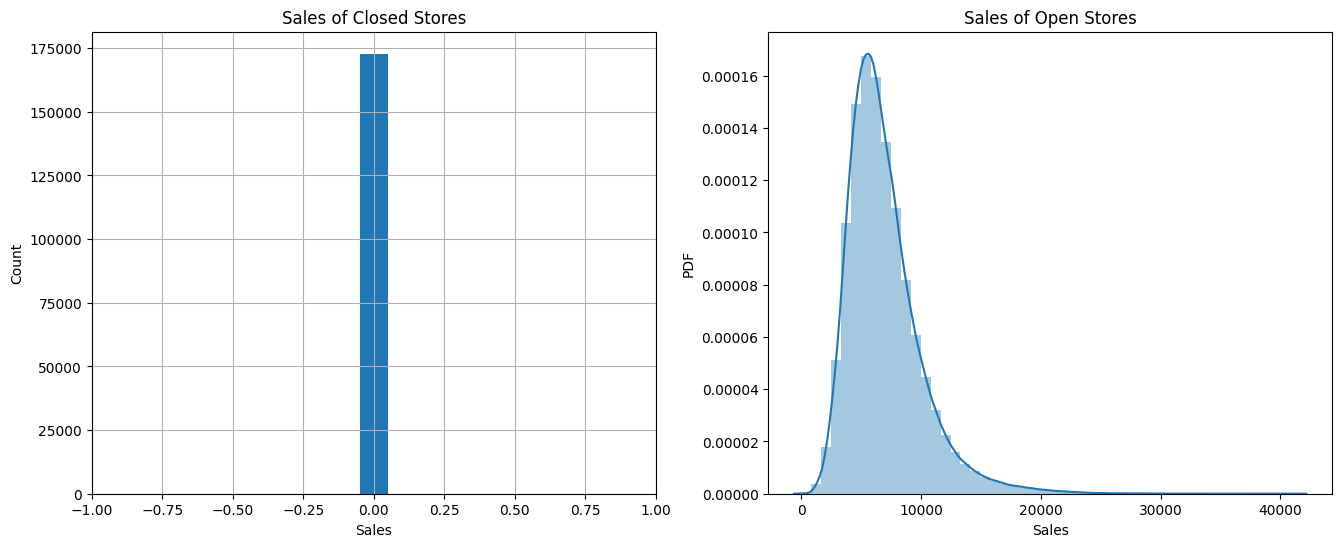

In [4]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')
ax1.set_title('Sales of Closed Stores')
plt.xlim(-1,1)
train.loc[train.Open==0].Sales.hist(align='left')

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Sales')
ax2.set_ylabel('PDF')
ax2.set_title('Sales of Open Stores')
sns.distplot(train.loc[train.Open!=0].Sales)

print('The skewness of Sales is {}'.format(train.loc[train.Open!=0].Sales.skew()))

因此，我们只采用店铺营业(Open!=0)时的数据进行训练。另外，我们不采用营业时Sales==0的数据。

In [5]:
train = train.loc[train.Open != 0]
train = train.loc[train.Sales > 0].reset_index(drop=True)

<a id='step3'></a>
## 3. 缺失值处理 

In [6]:
# train的缺失信息：无缺失
train[train.isnull().values==True]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [7]:
# test的缺失信息
test[test.isnull().values==True]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


<Axes: >

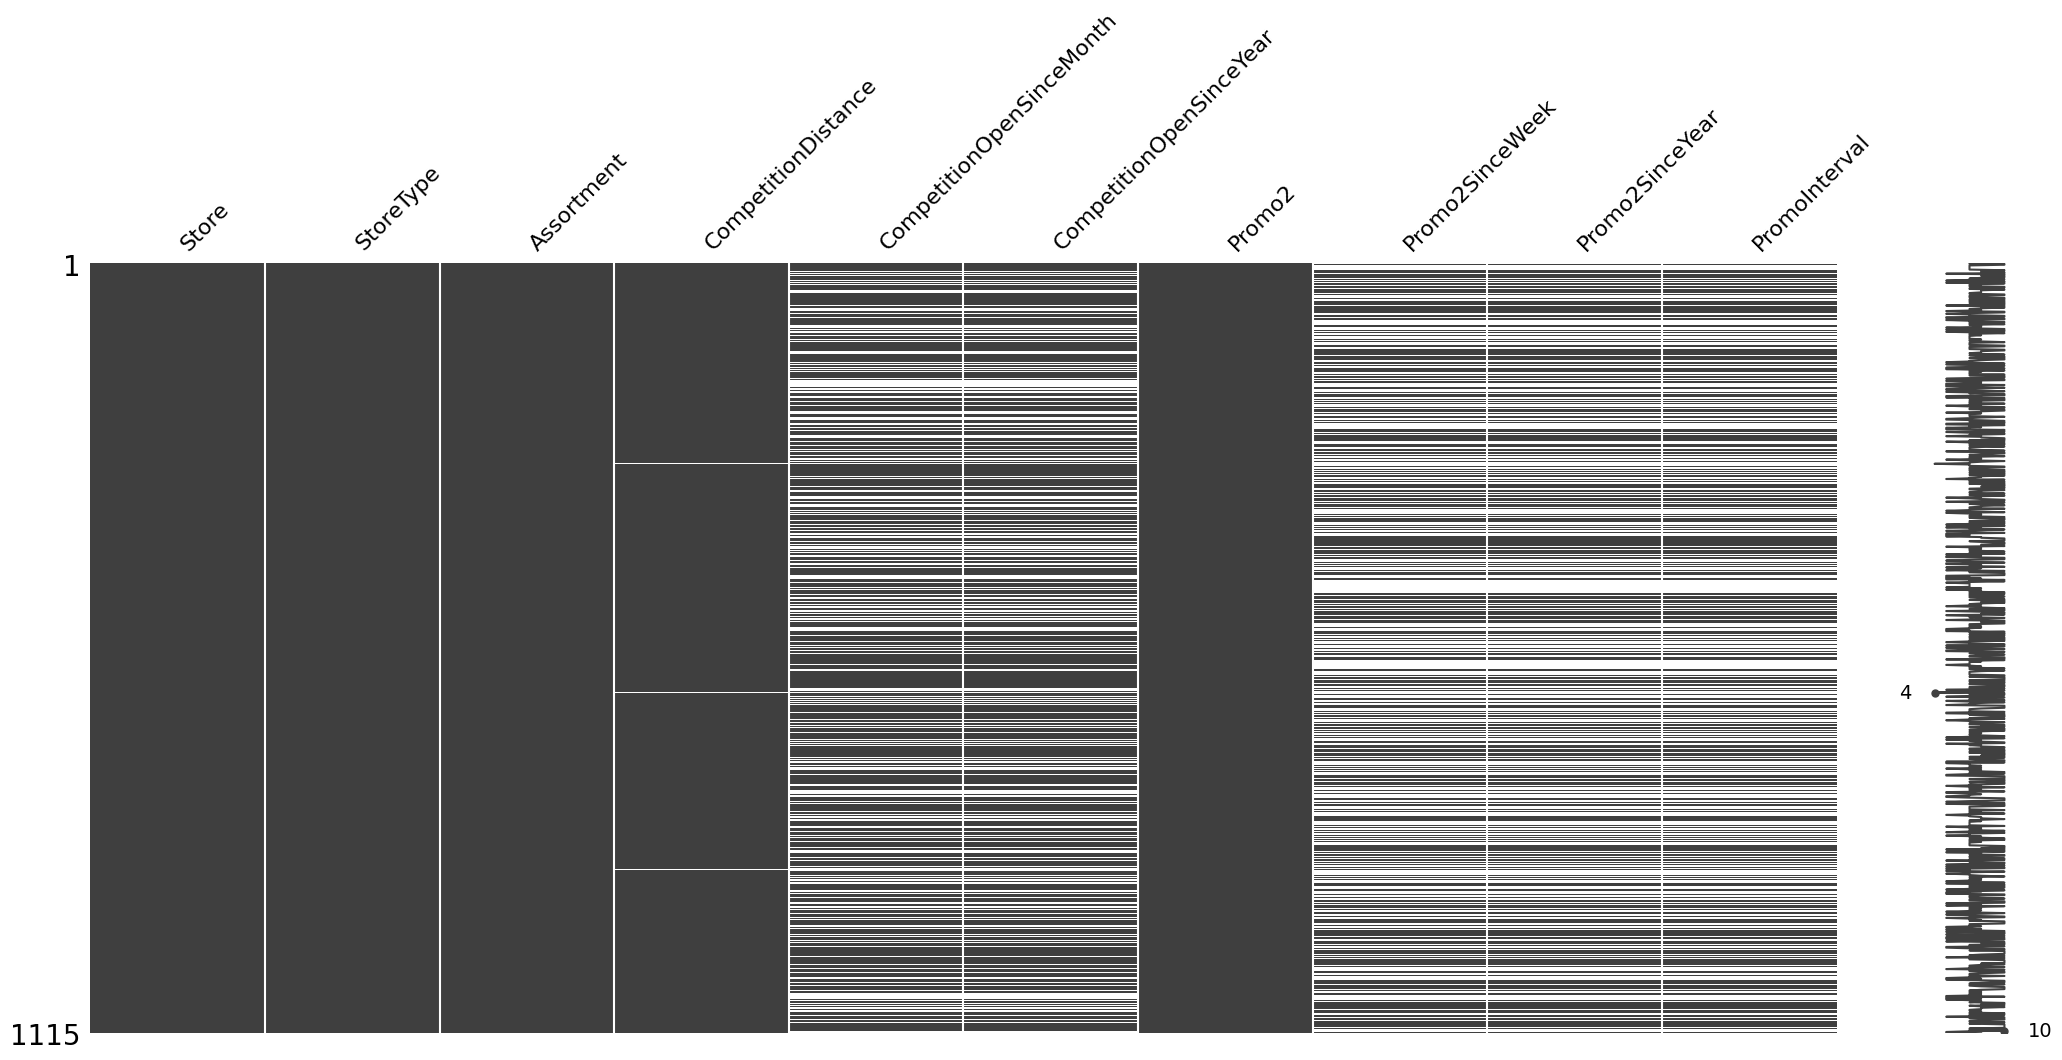

In [8]:
# store的缺失信息
msno.matrix(store)

可以看出，缺失信息集中出现在`test.csv`与`store.csv`中。下面我们对缺失值进行处理，并对特征进行合并：

In [9]:
# 默认test中的店铺全部正常营业
test.fillna(1,inplace=True)

# 对CompetitionDistance中的缺失值采用中位数进行填补
store.CompetitionDistance = store.CompetitionDistance.fillna(store.CompetitionDistance.median())

# 对其它缺失值全部补0
store.fillna(0,inplace=True)

<a id='question1'></a>
### __问题 1:__

回顾课上内容并查阅资料，归纳总结缺失值的处理方法。

__回答:__ 


In [10]:
# 特征合并
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

<a id='step4'></a>
## 4. 特征提取
### 4.1 定义特征提取函数

In [11]:
def build_features(features, data):

    # 直接使用的特征
    features.extend(['Store','CompetitionDistance','CompetitionOpenSinceMonth','StateHoliday','StoreType','Assortment',
                     'SchoolHoliday','CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])
    
    # 以下特征处理方式参考：https://blog.csdn.net/aicanghai_smile/article/details/80987666
    
    # 时间特征，使用dt进行处理
    features.extend(['Year','Month','Day','DayOfWeek','WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.isocalendar().week#data.Date.dt.weekofyear
    
    # 'CompetitionOpen'：竞争对手的已营业时间
    # 'PromoOpen'：竞争对手的已促销时间
    # 两个特征的单位均为月
    features.extend(['CompetitionOpen','PromoOpen'])
    data['CompetitionOpen'] = 12*(data.Year-data.CompetitionOpenSinceYear) + (data.Month-data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12*(data.Year-data.Promo2SinceYear) + (data.WeekOfYear-data.Promo2SinceWeek)/4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    # 'IsPromoMonth'：该天店铺是否处于促销月，1表示是，0表示否
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval==0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    
    # 字符特征转换为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)

### 4.2 特征提取

In [12]:
# 处理Date方便特征提取
train.Date = pd.to_datetime(train.Date, errors='coerce')
test.Date = pd.to_datetime(test.Date, errors='coerce')

# 使用features数组储存使用的特征
features = []

# 对train与test特征提取
build_features(features, train)
build_features([], test)

# 打印使用的特征
print(features)

/tmp/ipykernel_12410/3718081685.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.StoreType.replace(mappings, inplace=True)
/tmp/ipykernel_12410/3718081685.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.StoreType.replace(mappings, inplace=True)
/tmp/ipykernel_12410/3718081685.py:4

['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'StateHoliday', 'StoreType', 'Assortment', 'SchoolHoliday', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


/tmp/ipykernel_12410/3718081685.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.StateHoliday.replace(mappings, inplace=True)
/tmp/ipykernel_12410/3718081685.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.StoreType.replace(mappings, inplace=True)
/tmp/ipykernel_12410/3718081685.p

In [13]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1,3,...,0.0,,2015,7,31,31,82.0,24187.75,Jul,0
1,2,4,2015-07-31,6064,625,1,1,0,1,1,...,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.50,Jul,1
2,3,4,2015-07-31,8314,821,1,1,0,1,1,...,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,52.25,Jul,1
3,4,4,2015-07-31,13995,1498,1,1,0,1,3,...,0.0,,2015,7,31,31,70.0,24187.75,Jul,0
4,5,4,2015-07-31,4822,559,1,1,0,1,1,...,0.0,,2015,7,31,31,3.0,24187.75,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844333,682,1,2013-01-01,3375,566,1,0,1,1,2,...,0.0,,2013,1,1,1,76.0,24156.25,Jan,0
844334,733,1,2013-01-01,10765,2377,1,0,1,1,2,...,0.0,,2013,1,1,1,159.0,24156.25,Jan,0
844335,769,1,2013-01-01,5035,1248,1,0,1,1,2,...,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,24157.0,0.25,Jan,1
844336,948,1,2013-01-01,4491,1039,1,0,1,1,2,...,0.0,,2013,1,1,1,24157.0,24156.25,Jan,0


In [14]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,1,3,2015-09-17,1.0,1,0,0,3,1,...,0.0,,2015,9,17,38,84.0,24189.50,Sept,0
1,2,3,3,2015-09-17,1.0,1,0,0,1,1,...,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,105.0,54.00,Sept,0
2,3,7,3,2015-09-17,1.0,1,0,0,1,3,...,0.0,,2015,9,17,38,29.0,24189.50,Sept,0
3,4,8,3,2015-09-17,1.0,1,0,0,1,1,...,0.0,,2015,9,17,38,11.0,24189.50,Sept,0
4,5,9,3,2015-09-17,1.0,1,0,0,1,3,...,0.0,,2015,9,17,38,181.0,24189.50,Sept,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,5,2015-08-01,1.0,0,0,0,1,1,...,2013.0,"Jan,Apr,Jul,Oct",2015,8,1,31,14.0,24.00,Aug,0
41084,41085,1112,5,2015-08-01,1.0,0,0,0,3,3,...,0.0,,2015,8,1,31,112.0,24187.75,Aug,0
41085,41086,1113,5,2015-08-01,1.0,0,0,0,1,3,...,0.0,,2015,8,1,31,24188.0,24187.75,Aug,0
41086,41087,1114,5,2015-08-01,1.0,0,0,0,1,3,...,0.0,,2015,8,1,31,24188.0,24187.75,Aug,0


<a id='step5'></a>
## 5. 基准模型与测试

### 5.1 定义评价函数

由于需要预测连续值，因此需要采用回归模型。由于该项目是Kaggle赛题，测试集是使用根均方百分比误差(Root Mean Square Percentage Error, RMSPE)评测的，因此这里只能使用RMSPE。RMSPE的计算公式为：
$${\rm RMSPE} = \frac{1}{n}\sqrt{\sum\limits_{i = 1}^n {{{\left( {\frac{{{y_i} - {{\hat y}_i}}}{{{y_i}}}} \right)}^2}}}$$
其中$y_i$与${\hat y}_i$分别为第$i$个样本标签的真实值与预测值。

In [15]:
# 评价函数Rmspe
# 参考：https://www.kaggle.com/justdoit/xgboost-in-python-with-rmspe

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return "rmspe", rmspe

def neg_rmspe(yhat, y):
    y = np.expm1(y)
    yhat = np.expm1(yhat)
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y-yhat)**2))
    return -rmspe

### 5.2 基准测试

在上述特征基础与评价函数基础上，本文采用**决策回归树**模型进行基准测试。在代码中直接调用Sklearn中的`DecisionTreeRegressor`，配合K折交叉验证与网格搜索即可，主要调节的超参数为树的最大深度`max_depth`。

<a id='question2'></a>
### __问题 2:__

这里评分标准为何采用`neg_rmspe`？

__回答:__ 


In [17]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=2)

cv_sets = ShuffleSplit(n_splits=5, test_size=0.2)    
params = {'max_depth':range(20,26,2)}
scoring_fnc = make_scorer(neg_rmspe)

grid = GridSearchCV(regressor,params,scoring=scoring_fnc,cv=cv_sets)
grid = grid.fit(train[features], np.log1p(train.Sales))

DTR = grid.best_estimator_

In [18]:
# 显示最佳超参数
DTR.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 2,
 'splitter': 'best'}

In [19]:
# 生成上传文件
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(DTR.predict(test[features]))})
submission.to_csv("benchmark.csv", index=False)

模型在测试集上的Public Score为`0.18423`，Private Score为`0.22081`。下面使用XGBoost对基准测试结果进行提升。

<a id='step6'></a>
## 6. XGBoost
### 6.1 模型参数
主要调节的参数包括：
- `eta`：迭代步长；
- `max_depth`：单颗回归树的最大深度，较小导致欠拟合，较大导致过拟合；
- `subsample`：0-1之间，控制每棵树随机采样的比例，减小这个参数的值，算法会更加保守，避免过拟合。但如果这个值设置得过小，可能会导致欠拟合；
- `colsample_bytree`：0-1之间，用来控制每棵随机采样的特征的占比；
- `num_trees`：迭代步数。

In [20]:
# 在此进行参数调节
params = {'objective': 'reg:linear',
          'eta': 0.01,
          'max_depth': 11,
          'subsample': 0.5,
          'colsample_bytree': 0.5,
          'silent': 1,
          'seed': 1
          }
num_trees = 10000

### 6.2 模型训练

In [21]:
# 随机划分训练集与验证集
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(train, test_size=0.2, random_state=2)

dtrain = xgb.DMatrix(X_train[features], np.log1p(X_train.Sales))
dvalid = xgb.DMatrix(X_test[features], np.log1p(X_test.Sales))
dtest = xgb.DMatrix(test[features])

watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50, custom_metric=rmspe_xg, verbose_eval=True)

[0]	train-rmse:0.42369	train-rmspe:0.55908	eval-rmse:0.42358	eval-rmspe:0.54484


/home/huang/anaconda3/envs/edu/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:50:06] WARNING: /workspace/src/objective/regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()
/home/huang/anaconda3/envs/edu/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [19:50:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	train-rmse:0.42216	train-rmspe:0.55668	eval-rmse:0.42207	eval-rmspe:0.54241
[2]	train-rmse:0.42084	train-rmspe:0.55448	eval-rmse:0.42076	eval-rmspe:0.54018
[3]	train-rmse:0.41872	train-rmspe:0.55081	eval-rmse:0.41865	eval-rmspe:0.53629
[4]	train-rmse:0.41744	train-rmspe:0.54869	eval-rmse:0.41738	eval-rmspe:0.53408
[5]	train-rmse:0.41548	train-rmspe:0.54563	eval-rmse:0.41544	eval-rmspe:0.53104
[6]	train-rmse:0.41403	train-rmspe:0.54312	eval-rmse:0.41400	eval-rmspe:0.52846
[7]	train-rmse:0.41271	train-rmspe:0.54112	eval-rmse:0.41269	eval-rmspe:0.52648
[8]	train-rmse:0.41121	train-rmspe:0.53909	eval-rmse:0.41121	eval-rmspe:0.52450
[9]	train-rmse:0.41002	train-rmspe:0.53726	eval-rmse:0.41003	eval-rmspe:0.52261
[10]	train-rmse:0.40854	train-rmspe:0.53509	eval-rmse:0.40857	eval-rmspe:0.52016
[11]	train-rmse:0.40715	train-rmspe:0.53221	eval-rmse:0.40720	eval-rmspe:0.51740
[12]	train-rmse:0.40582	train-rmspe:0.52957	eval-rmse:0.40589	eval-rmspe:0.51477
[13]	train-rmse:0.40415	train-rmspe:0

<a id='question3'></a>
### __问题 3:__

思考此时XGBoost在使用什么损失函数进行训练？

__回答:__ 


### 6.3 生产提交文件

In [30]:
# 生成提交文件
test_probs = gbm.predict(xgb.DMatrix(test[features]), iteration_range=range(0,gbm.best_iteration))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.expm1(test_probs)})
submission.to_csv("xgboost.csv", index=False)

预测结果的Public Score为`0.10932`，Private Score为`0.12051`，已非常接近Top 10%的标准线`0.11773`。

### 6.4 Optuna超参数搜寻

In [31]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eta": trial.suggest_float("eta", 1e-3, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "tree_method": trial.suggest_categorical("tree_method", ["hist", "approx", "auto"]),
        "verbosity": 0,
        "seed": 1,
    }
    
    evals = [(dtrain, "train"), (dvalid, "eval")]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=300,
        evals=evals,
        custom_metric=rmspe_xg,      # ✅ 新版用 custom_metric
        early_stopping_rounds=200,
        verbose_eval=False
    )

    
    pred_log = model.predict(dvalid, iteration_range=(0, model.best_iteration+1))
    score = rmspe(np.expm1(dvalid.get_label()), np.expm1(pred_log))
    return score  # 最小化

In [32]:
study = optuna.create_study(direction="minimize",
                            sampler=TPESampler(seed=1),
                            pruner=MedianPruner(n_warmup_steps=20))
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2025-10-11 20:21:59,820] A new study created in memory with name: no-name-e88d27b6-4df3-403f-8413-4aa0e5188f1a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-11 20:22:12,073] Trial 0 finished with value: 0.24514915893400563 and parameters: {'eta': 0.010789816816471733, 'max_depth': 10, 'min_child_weight': 0.010007903854383781, 'subsample': 0.6511662863159199, 'colsample_bytree': 0.5733779454085566, 'gamma': 0.923385947687978, 'reg_alpha': 4.746154837062843e-07, 'reg_lambda': 1.2883876209377052e-05, 'tree_method': 'approx'}. Best is trial 0 with value: 0.24514915893400563.
[I 2025-10-11 20:22:18,185] Trial 1 finished with value: 0.26112304467089925 and parameters: {'eta': 0.04981633676156071, 'max_depth': 5, 'min_child_weight': 4.3087600478391295, 'subsample': 0.5136937965989631, 'colsample_bytree': 0.8352337550892011, 'gamma': 4.17304802367127, 'reg_alpha': 0.0010671081971401395, 'reg_lambda': 1.8343510276558088e-07, 'tree_method': 'auto'}. Best is trial 0 with value: 0.24514915893400563.
[I 2025-10-11 20:22:25,330] Trial 2 finished with value: 0.3228859858629424 and parameters: {'eta': 0.005975712481762454, 'max_depth': 9, 'min_

In [33]:
print("Best score:", study.best_value)

Best score: 0.12744971804038982


In [34]:
print("Best params:", study.best_params)

Best params: {'eta': 0.054725715030322704, 'max_depth': 9, 'min_child_weight': 4.13091409312447, 'subsample': 0.9178336440361367, 'colsample_bytree': 0.8300521542700788, 'gamma': 0.0785256443407576, 'reg_alpha': 0.0023233602630379365, 'reg_lambda': 1.3905473347145145, 'tree_method': 'approx'}


In [35]:
# —— 用最佳参数复训（可用 dtrain 全量 + 你自定义的 watchlist）——
best_params = study.best_params | {"objective": "reg:squarederror", "verbosity": 0, "seed": 1}
full_dtrain = xgb.DMatrix(train[features], label=np.log1p(train["Sales"].values))
final_model = xgb.train(
    params=best_params,
    dtrain=full_dtrain,
    num_boost_round=10000,
    custom_metric=rmspe_xg,
    early_stopping_rounds=200,
    evals=watchlist,
    verbose_eval=True
)

[0]	train-rmse:0.41592	train-rmspe:0.54473	eval-rmse:0.41582	eval-rmspe:0.53079
[1]	train-rmse:0.40805	train-rmspe:0.53116	eval-rmse:0.40790	eval-rmspe:0.51687
[2]	train-rmse:0.40092	train-rmspe:0.51898	eval-rmse:0.40074	eval-rmspe:0.50467
[3]	train-rmse:0.39315	train-rmspe:0.50421	eval-rmse:0.39297	eval-rmspe:0.49031
[4]	train-rmse:0.38594	train-rmspe:0.49098	eval-rmse:0.38579	eval-rmspe:0.47739
[5]	train-rmse:0.38046	train-rmspe:0.48253	eval-rmse:0.38026	eval-rmspe:0.46848
[6]	train-rmse:0.37428	train-rmspe:0.47156	eval-rmse:0.37409	eval-rmspe:0.45771
[7]	train-rmse:0.36902	train-rmspe:0.46383	eval-rmse:0.36881	eval-rmspe:0.44956
[8]	train-rmse:0.36435	train-rmspe:0.45569	eval-rmse:0.36410	eval-rmspe:0.44105
[9]	train-rmse:0.35901	train-rmspe:0.44733	eval-rmse:0.35879	eval-rmspe:0.43269
[10]	train-rmse:0.35430	train-rmspe:0.44064	eval-rmse:0.35411	eval-rmspe:0.42590
[11]	train-rmse:0.35006	train-rmspe:0.43480	eval-rmse:0.34990	eval-rmspe:0.41992
[12]	train-rmse:0.34629	train-rmspe:0.